## Reading the data

In [1]:
import pandas as pd
import numpy as np
from gensim.models.doc2vec import Doc2Vec, TaggedDocument
import matplotlib.pyplot as plt

df = pd.read_csv("../../corpus_sprint2_balanced_cpsi.csv", encoding="utf-8")
df = df.dropna()

model = Doc2Vec.load("../../model_doc2vec_balanced_20epochs")

## One hot encoding and concatenating

In [2]:
vectors = model.docvecs.vectors_docs

In [3]:
#print(df)
one_hot2 = pd.Categorical(df['Sub-product'])
df_dummies2 = pd.get_dummies(one_hot2)

one_hot3 = pd.Categorical(df['Issue'])
df_dummies3 = pd.get_dummies(one_hot3)

v_df = pd.DataFrame(vectors)
df_concat = pd.concat([v_df, df_dummies2, df_dummies3], axis = 1)
print(df_concat)

               0         1         2         3         4         5         6  \
0      -0.188312  0.235858 -0.160661 -0.062930  0.088282  0.184802  0.369231   
1      -0.069450  0.123566 -0.331953  0.132706  0.416698 -0.337001  0.119607   
2      -0.145901  0.255647  0.014258 -0.009380  0.239211 -0.127895  0.123045   
3      -0.074536  0.037086 -0.051584 -0.062005  0.204723 -0.108399  0.280387   
4       0.306871 -0.032056 -0.098984 -0.138455  0.197950 -0.033127 -0.198101   
...          ...       ...       ...       ...       ...       ...       ...   
111629 -0.131735  0.009762  0.033046 -0.530487 -0.132169  0.258420 -0.012071   
111630 -0.016358  0.296047  0.117149 -0.307706 -0.198284 -0.304725 -0.305938   
111631 -0.062303  0.288477  0.159682 -0.103658 -0.100076  0.008712 -0.103005   
111632 -0.288595  0.146657 -0.130089  0.103363 -0.111763  0.095894 -0.089777   
111633  0.192410  0.238593 -0.077316  0.058626  0.091606 -0.226398 -0.055350   

               7         8         9  .

## Applying k-means

In [4]:
from sklearn.cluster import KMeans
from sklearn import metrics

### Visual with elbow

1
2
3
4
5
6
7
8
9
10
11
12
13
14
15
16
17
18
19
20
21
22
23
24


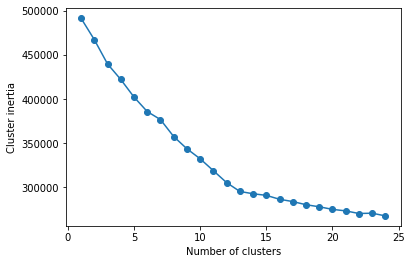

In [5]:
inertia = []
k_min=1
k_max=25
for i in range(k_min, k_max):
    print(i)
    km = KMeans(n_clusters=i,init='k-means++')
    km.fit(df_concat)
    inertia.append(km.inertia_)

plt.plot(range(k_min,k_max), inertia,marker='o')
plt.xlabel('Number of clusters')
plt.ylabel('Cluster inertia')
plt.show()

### Automatic with silhouette

In [10]:
from sklearn.metrics import silhouette_samples, silhouette_score
import matplotlib.cm as cm
range_n_clusters = [2, 3, 4]

for n_clusters in range_n_clusters:
    # Create a subplot with 1 row and 2 columns
    fig, (ax1, ax2) = plt.subplots(1, 2)
    fig.set_size_inches(18, 7)

    # The 1st subplot is the silhouette plot
    # The silhouette coefficient can range from -1, 1 but in this example all
    # lie within [-0.1, 1]
    ax1.set_xlim([-0.1, 1])
    # The (n_clusters+1)*10 is for inserting blank space between silhouette
    # plots of individual clusters, to demarcate them clearly.
    ax1.set_ylim([0, len(vectors) + (n_clusters + 1) * 10])

    # Initialize the clusterer with n_clusters value and a random generator
    # seed of 10 for reproducibility.
    clusterer = KMeans(n_clusters=n_clusters, random_state=10)
    cluster_labels = clusterer.fit_predict(vectors)

    # The silhouette_score gives the average value for all the samples.
    # This gives a perspective into the density and separation of the formed
    # clusters
    silhouette_avg = silhouette_score(vectors, cluster_labels)
    print("For n_clusters =", n_clusters,
          "The average silhouette_score is :", silhouette_avg)

    # Compute the silhouette scores for each sample
    sample_silhouette_values = silhouette_samples(vectors, cluster_labels)

    y_lower = 10
    for i in range(n_clusters):
        # Aggregate the silhouette scores for samples belonging to
        # cluster i, and sort them
        ith_cluster_silhouette_values = \
            sample_silhouette_values[cluster_labels == i]

        ith_cluster_silhouette_values.sort()

        size_cluster_i = ith_cluster_silhouette_values.shape[0]
        y_upper = y_lower + size_cluster_i

        color = cm.nipy_spectral(float(i) / n_clusters)
        ax1.fill_betweenx(np.arange(y_lower, y_upper),
                          0, ith_cluster_silhouette_values,
                          facecolor=color, edgecolor=color, alpha=0.7)

        # Label the silhouette plots with their cluster numbers at the middle
        ax1.text(-0.05, y_lower + 0.5 * size_cluster_i, str(i))

        # Compute the new y_lower for next plot
        y_lower = y_upper + 10  # 10 for the 0 samples

    ax1.set_title("The silhouette plot for the various clusters.")
    ax1.set_xlabel("The silhouette coefficient values")
    ax1.set_ylabel("Cluster label")

    # The vertical line for average silhouette score of all the values
    ax1.axvline(x=silhouette_avg, color="red", linestyle="--")

    ax1.set_yticks([])  # Clear the yaxis labels / ticks
    ax1.set_xticks([-0.1, 0, 0.2, 0.4, 0.6, 0.8, 1])

    # 2nd Plot showing the actual clusters formed
    colors = cm.nipy_spectral(cluster_labels.astype(float) / n_clusters)
    ax2.scatter(vectors[:, 0], vectors[:, 1], marker='.', s=30, lw=0, alpha=0.7,
                c=colors, edgecolor='k')

    # Labeling the clusters
    centers = clusterer.cluster_centers_
    # Draw white circles at cluster centers
    ax2.scatter(centers[:, 0], centers[:, 1], marker='o',
                c="white", alpha=1, s=200, edgecolor='k')

    for i, c in enumerate(centers):
        ax2.scatter(c[0], c[1], marker='$%d$' % i, alpha=1,
                    s=50, edgecolor='k')

    ax2.set_title("The visualization of the clustered data.")
    ax2.set_xlabel("Feature space for the 1st feature")
    ax2.set_ylabel("Feature space for the 2nd feature")

    plt.suptitle(("Silhouette analysis for KMeans clustering on sample data "
                  "with n_clusters = %d" % n_clusters),
                 fontsize=14, fontweight='bold')

plt.show()

6
Train done
Silhouette done
0.13331369
13
Train done
Silhouette done
0.2128088
Cluster id labels for inputted data
[0 0 7 ... 2 2 2]
Centroids data
[[-5.54599166e-02 -1.45852380e-02 -1.06791064e-01 ...  1.03086606e-02
  -6.46337867e-07 -1.22468919e-07]
 [-8.00356716e-02  3.50124314e-02 -8.20507854e-03 ...  3.21888365e-08
  -9.13627446e-07 -1.48895197e-07]
 [ 3.02012600e-02  1.05728664e-01 -5.62472753e-02 ...  3.24216671e-08
  -9.30391252e-07 -1.50525011e-07]
 ...
 [-8.98926407e-02 -3.90097648e-02 -9.73695815e-02 ...  3.10246833e-08
  -8.25151801e-07  2.26242952e-02]
 [ 1.38851963e-02  2.15379782e-02 -9.50428173e-02 ...  3.26544978e-08
  -9.43429768e-07 -1.51921995e-07]
 [-8.99317190e-02 -4.20005247e-02 -9.62675065e-02 ...  3.30037437e-08
  -9.69506800e-07 -1.54366717e-07]]
Score (Opposite of the value of X on the K-means objective which is Sum of distances of samples to their closest cluster center):
-295261.78
Silhouette_score: 
0.2128088
